# Descripción del proyecto
La cadena de gimnasios Model Fitness está desarrollando una estrategia de interacción con clientes basada en datos analíticos.

Uno de los problemas más comunes que enfrentan los gimnasios y otros servicios es la pérdida de clientes. ¿Cómo descubres si un/a cliente ya no está contigo? Puedes calcular la pérdida en función de las personas que se deshacen de sus cuentas o no renuevan sus contratos. Sin embargo, a veces no es obvio que un/a cliente se haya ido: puede que se vaya de puntillas.

Los indicadores de pérdida varían de un campo a otro. Si un usuario o una usuaria compra en una tienda en línea con poca frecuencia, pero con regularidad, no se puede decir que ha huido. Pero si durante dos semanas no ha abierto un canal que se actualiza a diario, es motivo de preocupación: es posible que tu seguidor o seguidor/a se haya aburrido y te haya abandonado.

En el caso de un gimnasio, tiene sentido decir que un/a cliente se ha ido si no viene durante un mes. Por supuesto, es posible que estén en Cancún y retomen sus visitas cuando regresen, pero ese no es un caso típico. Por lo general, si un/a cliente se une, viene varias veces y luego desaparece, es poco probable que regrese.

Con el fin de combatir la cancelación, Model Fitness ha digitalizado varios de sus perfiles de clientes. Tu tarea consiste en analizarlos y elaborar una estrategia de retención de clientes.

Tienes que:

* Aprender a predecir la probabilidad de pérdida (para el próximo mes) para cada cliente.
* Elaborar retratos de usuarios típicos: selecciona los grupos más destacados y describe sus características principales.
* Analizar los factores que más impactan la pérdida.
* Sacar conclusiones básicas y elaborar recomendaciones para mejorar la atención al cliente:
    * identificar a los grupos objetivo;
    * sugerir medidas para reducir la rotación;
    * describir cualquier otro patrón que observes con respecto a la interacción con los clientes.

## Paso 1. Descargar los datos

### Importar Librerias

In [12]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans


In [13]:
data_gym = pd.read_csv("gym_churn_us.csv")

## Llevar a cabo el análisis exploratorio de datos (EDA)

In [14]:
def eda_cancelaciones(df, target_column):
    """
    Realiza un análisis exploratorio de datos (EDA) en un DataFrame.
    
    Parámetros:
    df (DataFrame): El dataset a analizar.
    target_column (str): Nombre de la columna que indica cancelación (ejemplo: 'churn', 'cancelado').
    
    Retorno:
    No devuelve nada, pero muestra estadísticas y gráficos.
    """
    
    print("="*50)
    print(" INFORMACIÓN GENERAL DEL DATAFRAME")
    print("="*50)
    print(df.info())

    print("\n" + "="*50)
    print(" VALORES NULOS")
    print("="*50)
    print(df.isnull().sum())

    print("\n" + "="*50)
    print(" ESTADÍSTICAS DESCRIPTIVAS")
    print("="*50)
    print(df.describe().T)

    print("\n" + "="*50)
    print(f" COMPARACIÓN ENTRE GRUPOS ({target_column})")
    print("="*50)
    print(df.groupby(target_column).mean())

    print("\n" + "="*50)
    print(" DISTRIBUCIÓN DE VARIABLES POR GRUPO")
    print("="*50)

    # Definir colores para los histogramas
    colors = ['#FF9999', '#66B2FF']
    
    # Variables numéricas
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns

    for col in num_cols:
        plt.figure(figsize=(10, 4))
        sns.histplot(df[df[target_column] == 0][col], bins=30, kde=True, color=colors[0], label="Se quedaron")
        sns.histplot(df[df[target_column] == 1][col], bins=30, kde=True, color=colors[1], label="Cancelaron")
        plt.title(f"Distribución de {col}")
        plt.legend()
        plt.show()

    print("\n" + "="*50)
    print(" MATRIZ DE CORRELACIÓN")
    print("="*50)

    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Matriz de Correlación")
    plt.show()

    print("\n **Análisis Exploratorio Completo Finalizado** ")

 INFORMACIÓN GENERAL DEL DATAFRAME
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_t

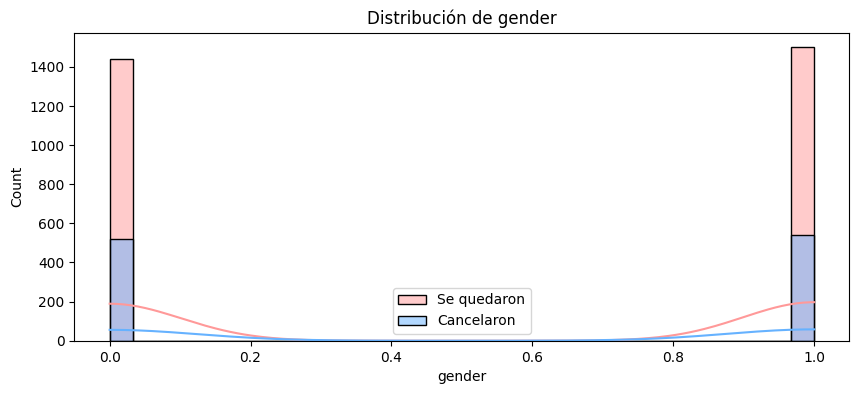

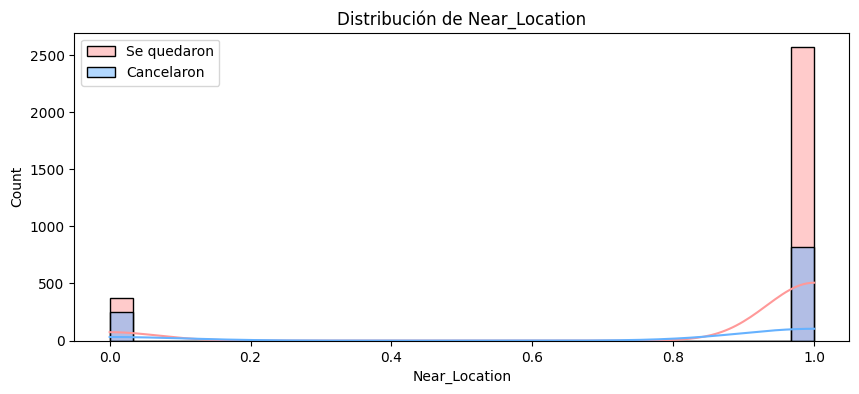

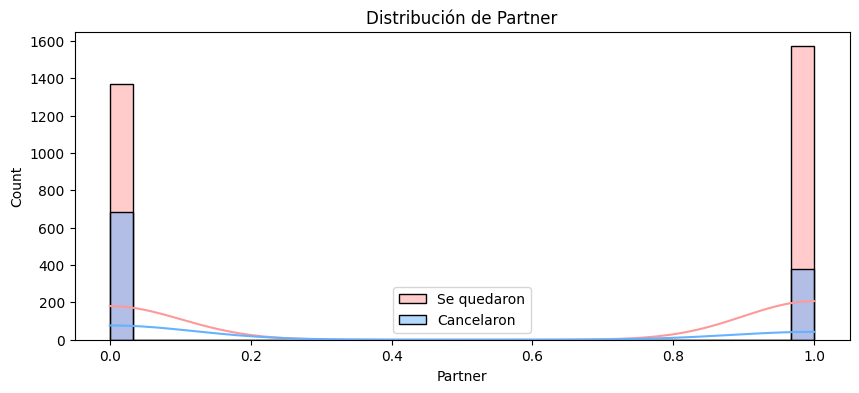

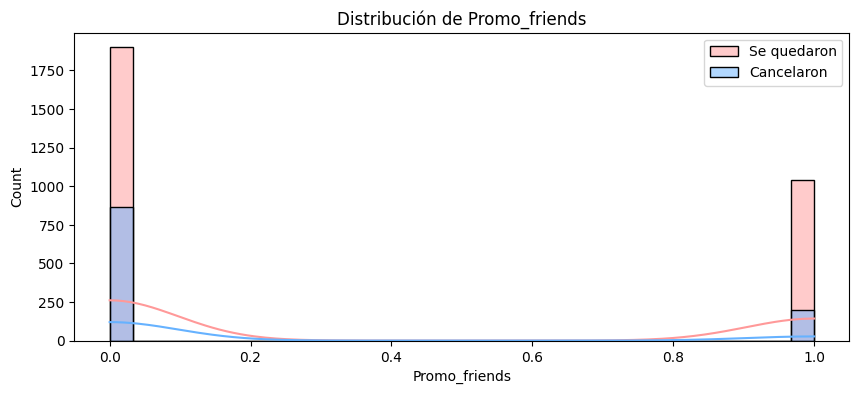

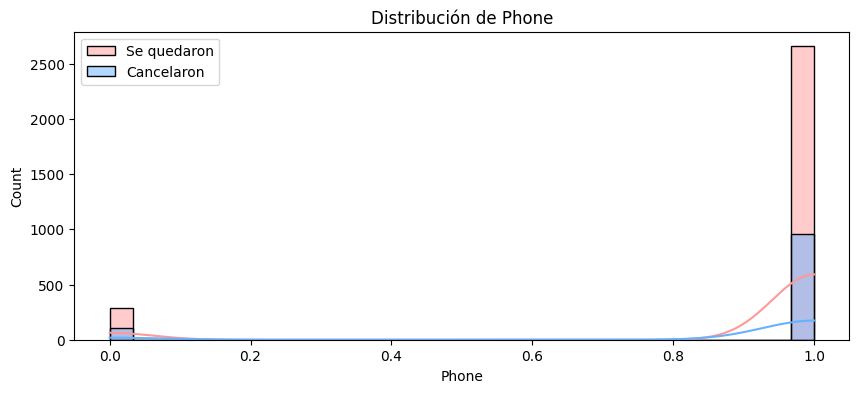

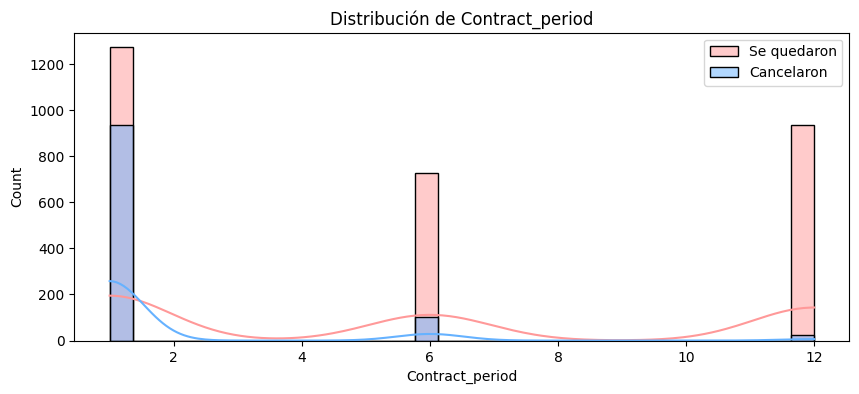

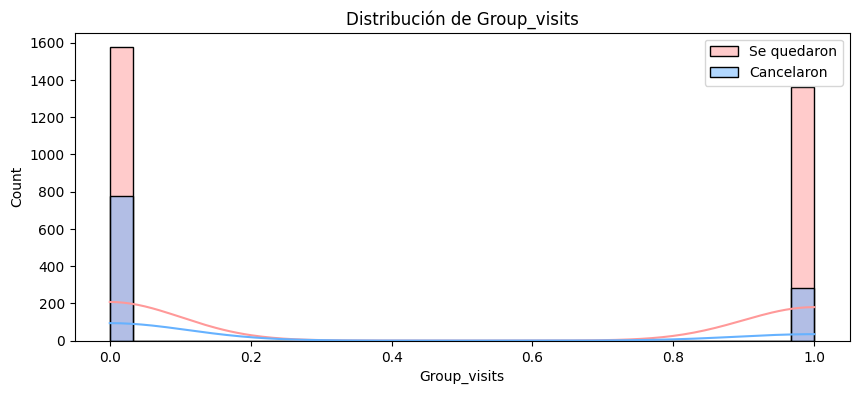

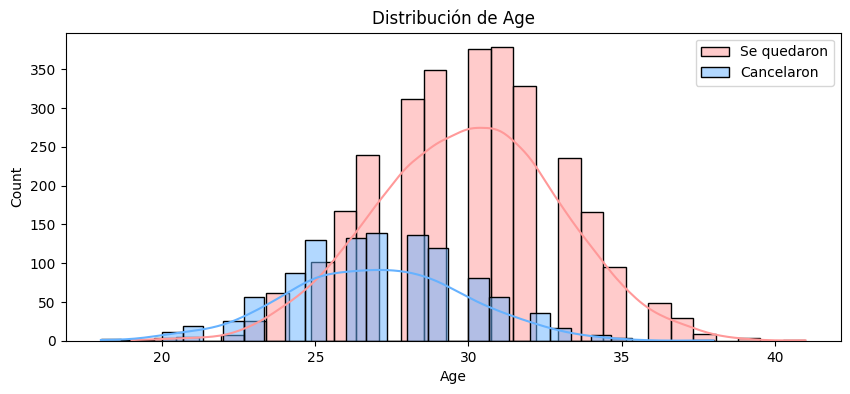

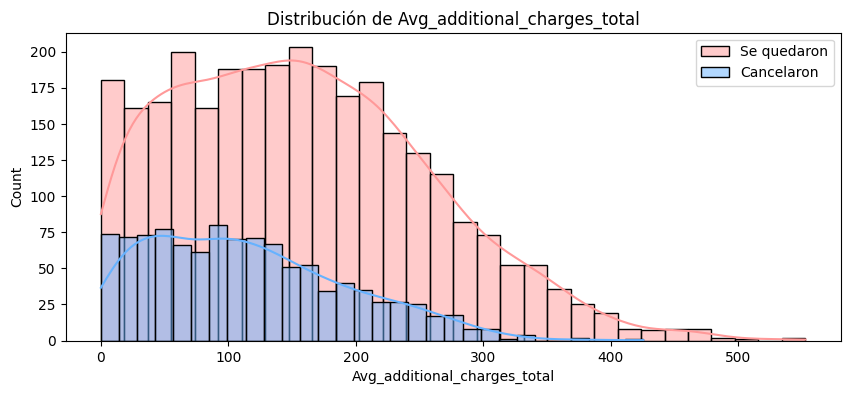

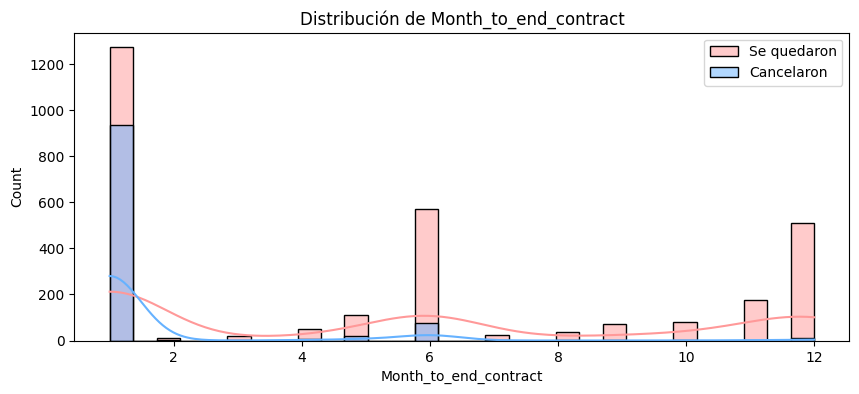

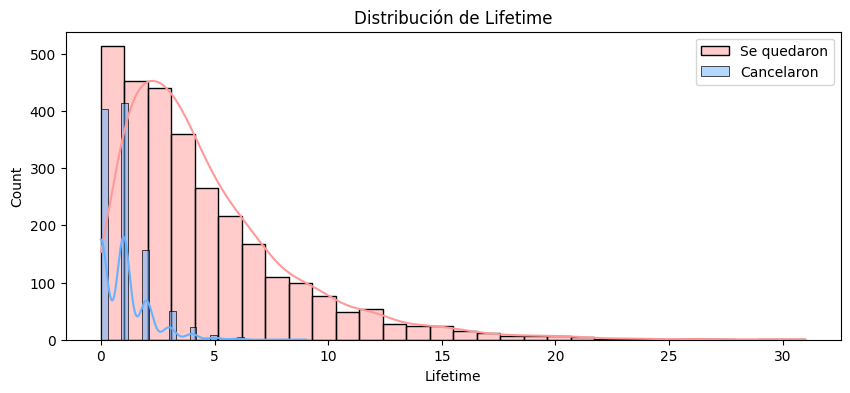

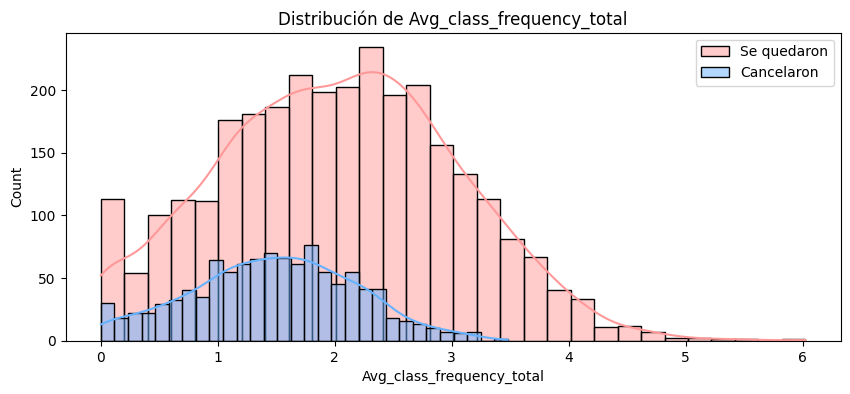

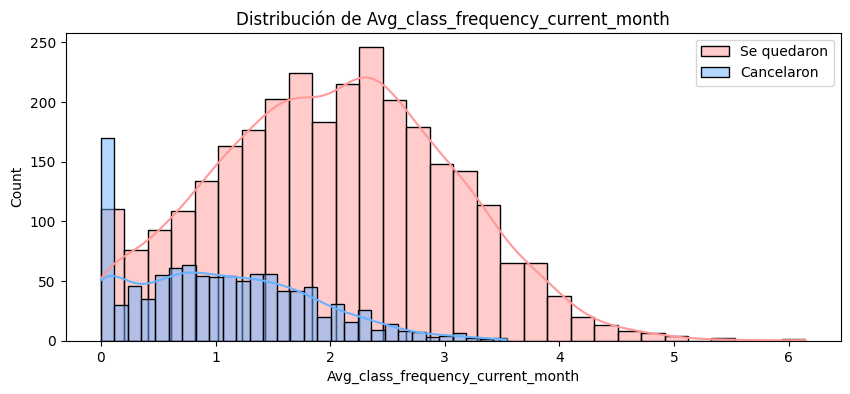

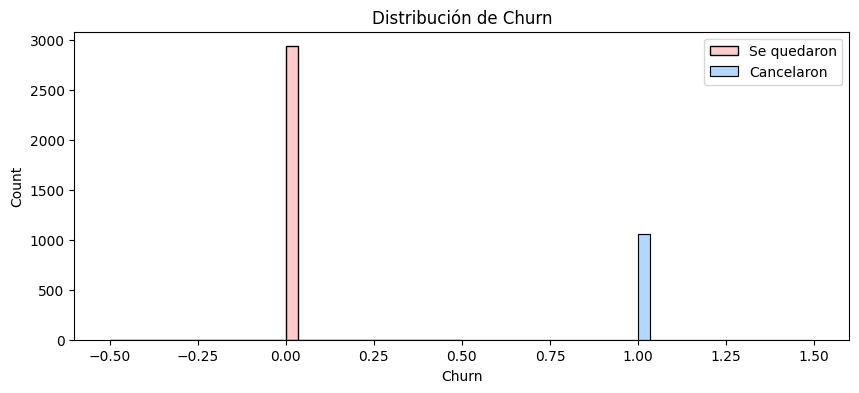


 MATRIZ DE CORRELACIÓN


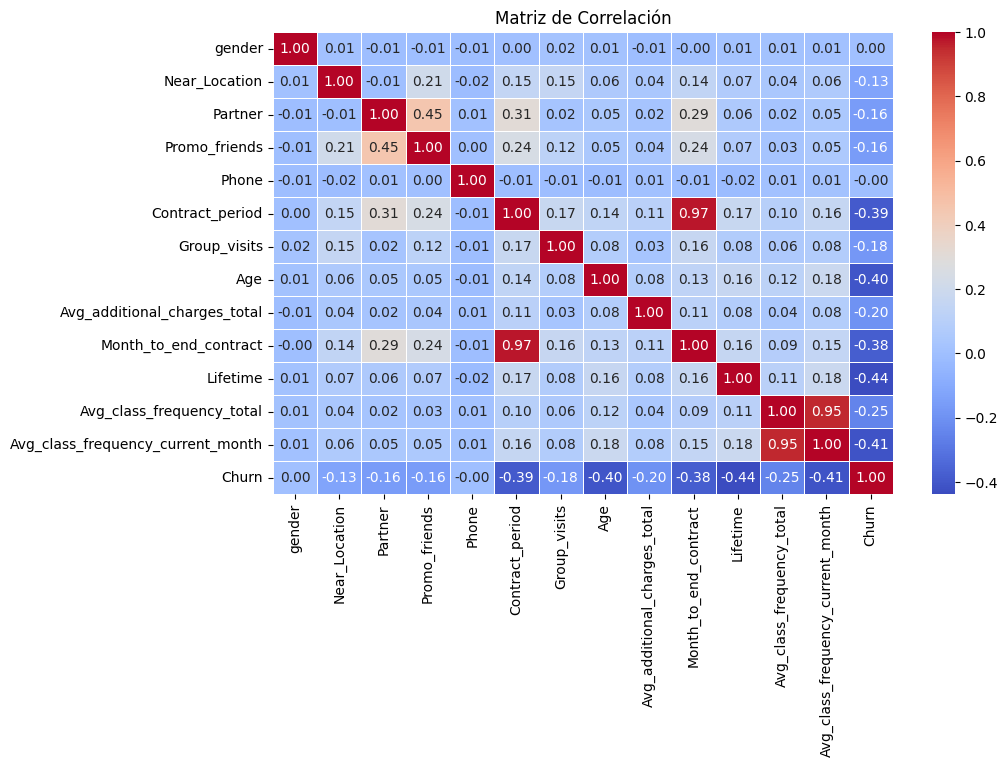


 **Análisis Exploratorio Completo Finalizado** 


In [15]:
eda_cancelaciones(data_gym,"Churn")

## Paso 3. Construir un modelo para predecir la cancelación de usuarios

In [16]:
def entrenar_modelos(df):
    """
    Construye y evalúa modelos de clasificación binaria para predecir la cancelación de usuarios.
    
    Parámetros:
    df (DataFrame): Dataset con información de los clientes.
    
    Retorno:
    No devuelve nada, pero imprime métricas de rendimiento de los modelos.
    """
    
    print("="*60)
    print(" PREPARACIÓN DE LOS DATOS")
    print("="*60)

    # Seleccionar características (X) y variable objetivo (y)
    X = df.drop(columns=['Churn', 'gender', 'Phone'])  # Eliminamos Churn (objetivo) y datos irrelevantes
    y = df['Churn']

    # Dividir datos en entrenamiento (80%) y validación (20%)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Normalización de variables numéricas
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)

    print("✔ Datos divididos y normalizados.")

    print("\n" + "="*60)
    print(" MODELO 1: REGRESIÓN LOGÍSTICA")
    print("="*60)

    # Entrenar Regresión Logística
    log_model = LogisticRegression(random_state=42)
    log_model.fit(X_train, y_train)
    y_pred_log = log_model.predict(X_valid)

    # Evaluación de Regresión Logística
    print("Accuracy:", accuracy_score(y_valid, y_pred_log))
    print("Precision:", precision_score(y_valid, y_pred_log))
    print("Recall:", recall_score(y_valid, y_pred_log))
    print("\nMatriz de Clasificación:\n", classification_report(y_valid, y_pred_log))

    print("\n" + "="*60)
    print(" MODELO 2: BOSQUE ALEATORIO")
    print("="*60)

    # Entrenar Bosque Aleatorio
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_valid)

    # Evaluación de Bosque Aleatorio
    print("Accuracy:", accuracy_score(y_valid, y_pred_rf))
    print("Precision:", precision_score(y_valid, y_pred_rf))
    print("Recall:", recall_score(y_valid, y_pred_rf))
    print("\nMatriz de Clasificación:\n", classification_report(y_valid, y_pred_rf))

    print("\n **Comparación de Modelos Finalizada** ")

In [17]:
entrenar_modelos(data_gym)

 PREPARACIÓN DE LOS DATOS
✔ Datos divididos y normalizados.

 MODELO 1: REGRESIÓN LOGÍSTICA
Accuracy: 0.925
Precision: 0.88
Recall: 0.8301886792452831

Matriz de Clasificación:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       588
           1       0.88      0.83      0.85       212

    accuracy                           0.93       800
   macro avg       0.91      0.89      0.90       800
weighted avg       0.92      0.93      0.92       800


 MODELO 2: BOSQUE ALEATORIO
Accuracy: 0.92625
Precision: 0.8844221105527639
Recall: 0.8301886792452831

Matriz de Clasificación:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       588
           1       0.88      0.83      0.86       212

    accuracy                           0.93       800
   macro avg       0.91      0.90      0.90       800
weighted avg       0.93      0.93      0.93       800


 **Comparación de Modelos Finalizada

## Paso 4. Crear clústeres de usuarios/as

In [18]:
def clustering_gym(df):
    """
    Realiza clustering en los datos de clientes del gimnasio.
    
    Parámetros:
    df (DataFrame): Dataset con información de los clientes.

    Retorno:
    No devuelve nada, pero imprime estadísticas y gráficos.
    """

    print("="*60)
    print(" PREPARACIÓN DE LOS DATOS")
    print("="*60)

    # Eliminar la columna de cancelación y variables irrelevantes
    df_clustering = df.drop(columns=['Churn', 'gender', 'Phone'])

    # Estandarizar los datos
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_clustering)

    print("✔ Datos estandarizados.")

    print("\n" + "="*60)
    print(" DENDROGRAMA PARA IDENTIFICAR NÚMERO DE CLÚSTERES")
    print("="*60)

    # Crear matriz de distancias y dendrograma
    plt.figure(figsize=(12, 6))
    linked = linkage(df_scaled, method='ward')
    dendrogram(linked)
    plt.title("Dendrograma de Clustering Jerárquico")
    plt.xlabel("Índice de Clientes")
    plt.ylabel("Distancia Euclidiana")
    plt.show()

    print("\n" + "="*60)
    print(" ENTRENAMIENTO DE K-MEANS (n_clusters=5)")
    print("="*60)

    # Entrenar modelo K-Means
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    df["Cluster"] = kmeans.fit_predict(df_scaled)

    print("✔ Clustering completado.")

    print("\n" + "="*60)
    print(" ESTADÍSTICAS DE CADA CLÚSTER")
    print("="*60)
    print(df.groupby("Cluster").mean())

    print("\n" + "="*60)
    print(" DISTRIBUCIÓN DE VARIABLES POR CLÚSTER")
    print("="*60)

    num_cols = df_clustering.columns

    for col in num_cols:
        plt.figure(figsize=(10, 4))
        sns.histplot(df, x=col, hue="Cluster", bins=30, palette="Set1", kde=True)
        plt.title(f"Distribución de {col} por Clúster")
        plt.show()

    print("\n" + "="*60)
    print(" TASA DE CANCELACIÓN POR CLÚSTER")
    print("="*60)
    print(df.groupby("Cluster")["Churn"].mean())

    print("\n **Clustering de Usuarios Finalizado** ")


 PREPARACIÓN DE LOS DATOS
✔ Datos estandarizados.

 DENDROGRAMA PARA IDENTIFICAR NÚMERO DE CLÚSTERES


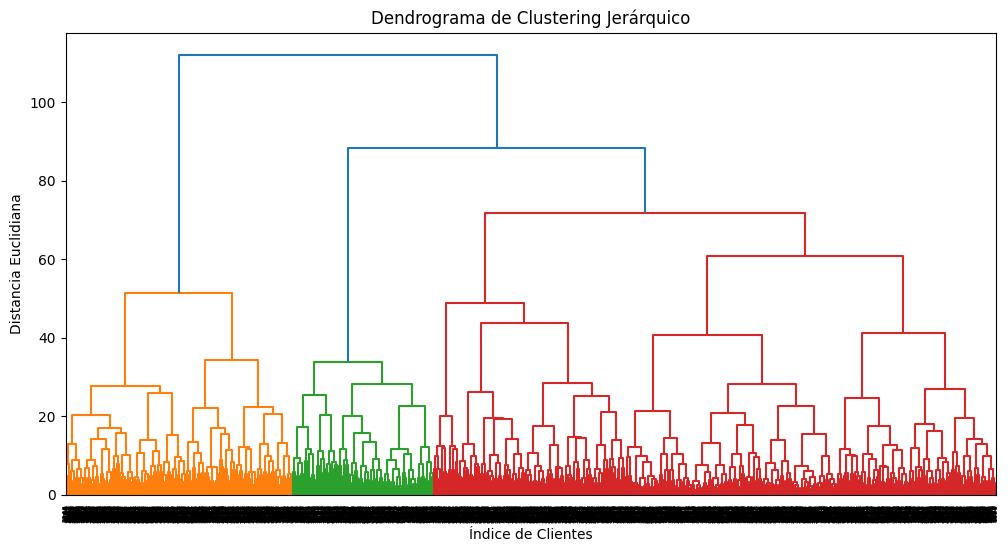


 ENTRENAMIENTO DE K-MEANS (n_clusters=5)
✔ Clustering completado.

 ESTADÍSTICAS DE CADA CLÚSTER
           gender  Near_Location   Partner  Promo_friends     Phone  \
Cluster                                                               
0        0.500000       1.000000  0.241563       0.020426  0.901421   
1        0.504301       0.944086  0.740860       0.488172  0.901075   
2        0.492308       0.998462  0.816923       1.000000  0.896923   
3        0.498155       0.000000  0.468635       0.077491  0.915129   
4        0.557181       0.968085  0.267287       0.086436  0.906915   

         Contract_period  Group_visits        Age  \
Cluster                                             
0               1.960036      0.328597  28.193606   
1              11.909677      0.552688  29.909677   
2               3.136923      0.453846  29.220000   
3               2.214022      0.215867  28.474170   
4               2.929521      0.469415  30.251330   

         Avg_additional_charges_

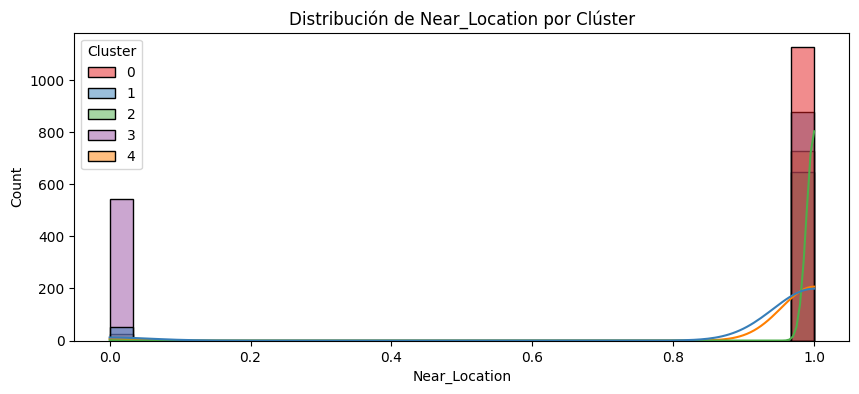

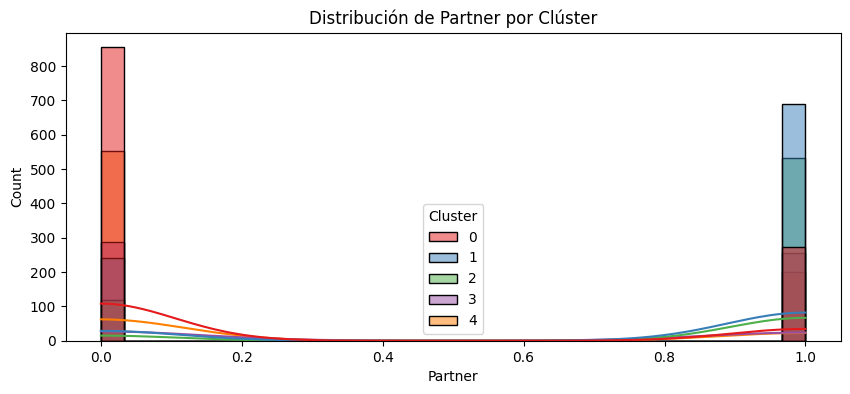

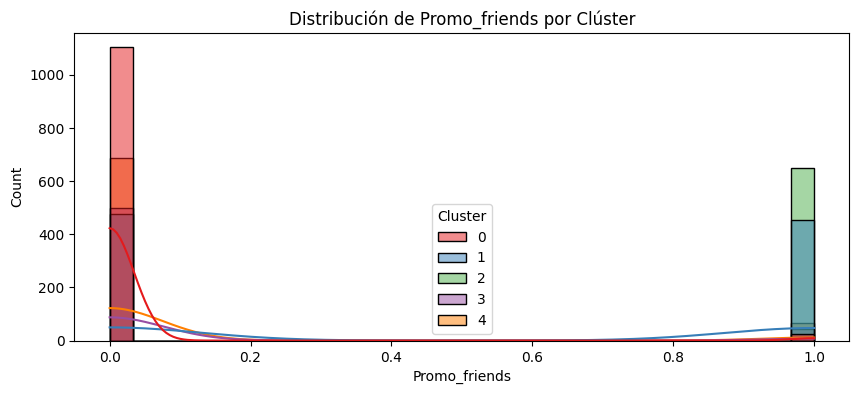

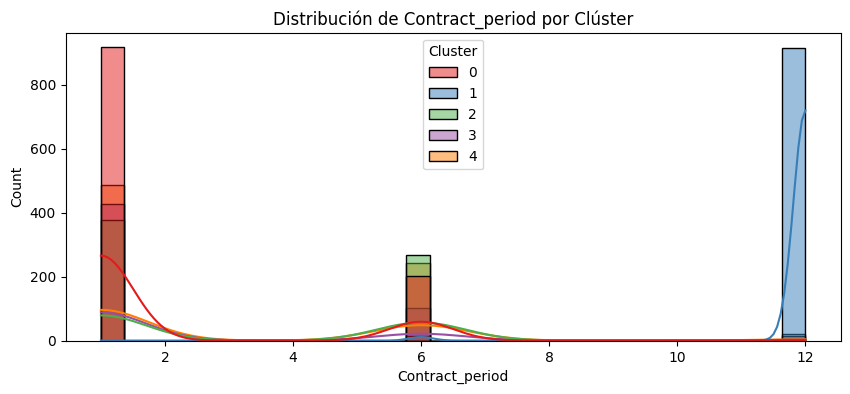

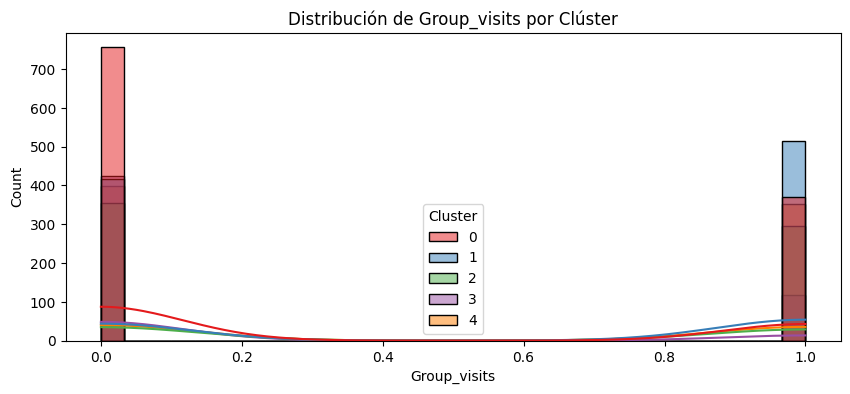

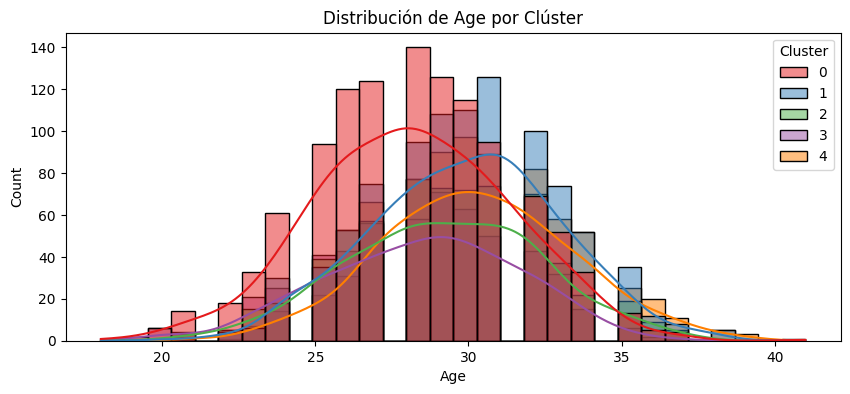

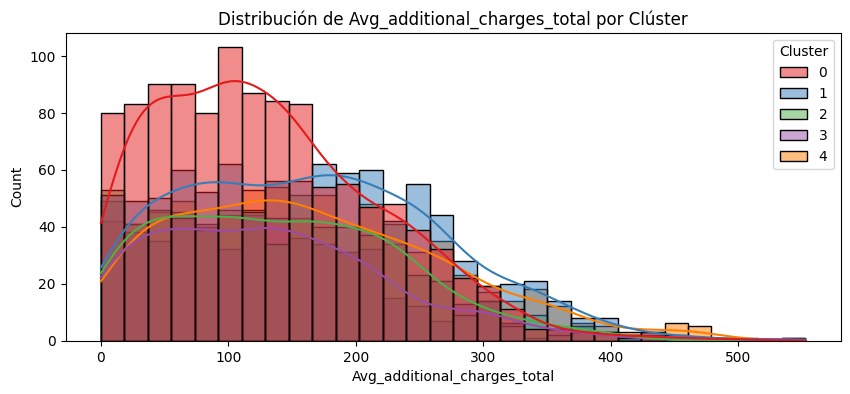

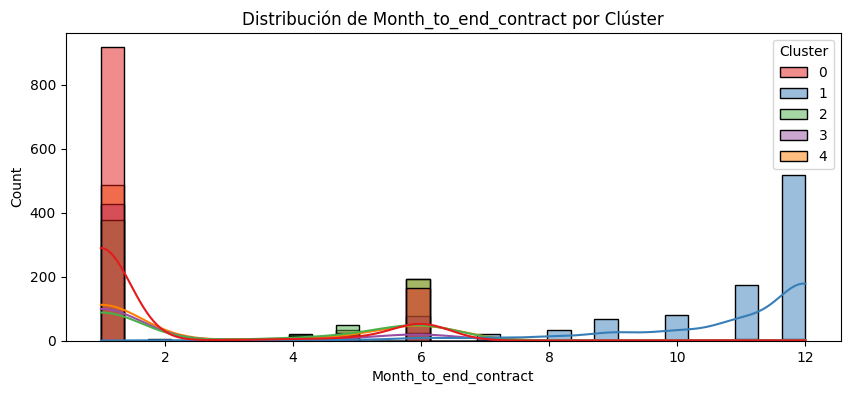

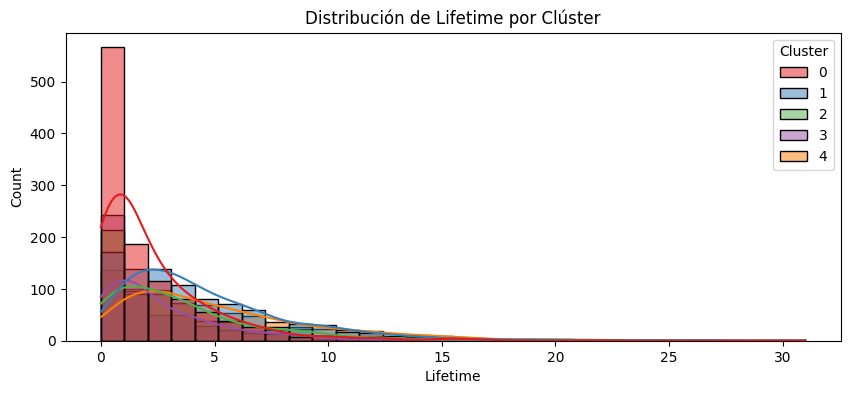

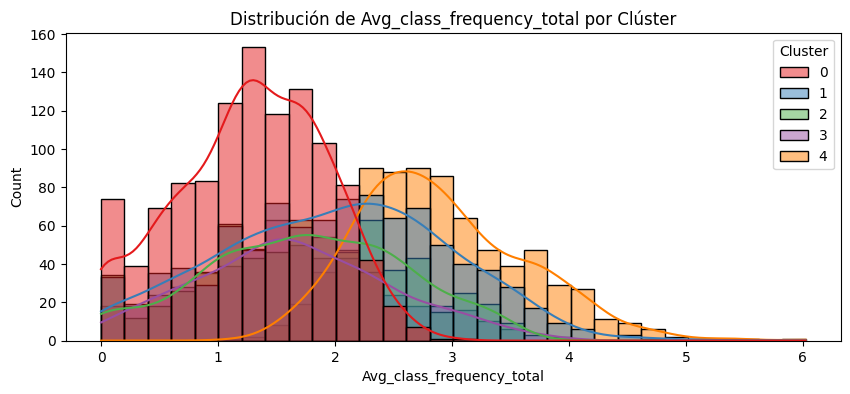

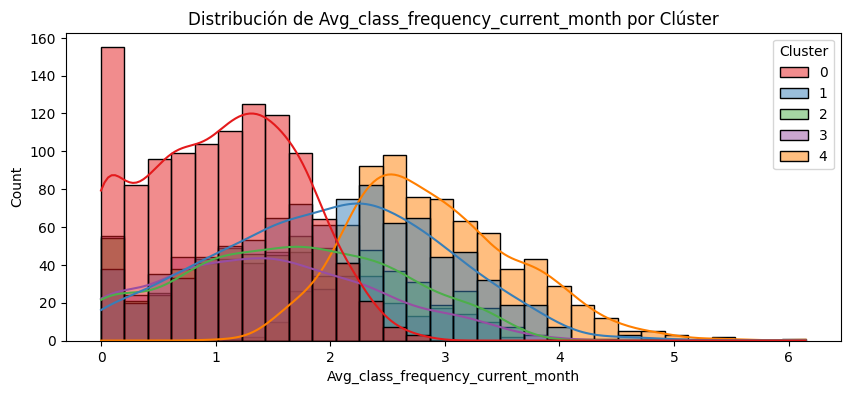


 TASA DE CANCELACIÓN POR CLÚSTER
Cluster
0    0.525755
1    0.022581
2    0.246154
3    0.452030
4    0.057181
Name: Churn, dtype: float64

 **Clustering de Usuarios Finalizado** 


In [19]:
clustering_gym(data_gym)

## Paso 5. Saca conclusiones y haz recomendaciones básicas sobre el trabajo con clientes

# Conclusiones
## EDA
### Al analizar los datos obtenidos podemos observar algunas diferencias entre los clientes que se quedan y los que se van:
* Duracion del contrato: Los clientes que se quedan tienen contratos cercanos a los 6 meses y los que se van son menores a 2 meses.  Los contratos cortos están altamente asociados con la cancelación.
* Tiempo en el gym: Los clientes que se quedan tienen en promedio 4.7 meses, mientras que los que se van tienen un promedio de 1 mes. Si un cliente no se queda al menos 1 mes, hay una alta probabilidad de que no renueve.
* Clases Grupales: 46.4% de los clientes que se quedan participan en clases grupales. Las clases grupales parecen aumentar la retención de clientes.
* Ubicación: 87.3% de los clientes que se quedan viven/trabajan cerca del gimnasio. La ubicación es un factor clave en la retención de clientes.
## Clusters
*Alto riesgo (el 52% cancelan): Contratos cortos (1.96 meses), frecuencia de visitas baja (1.29 visitas/semana), baja participación en clases grupales (32.8%)
Estrategias  Ofrecer  extender la membresía antes del vencimiento. enviar recordatorios  para la asistencia, fomentar la participación en clases grupales con promociones.
* Riesgo (45% cancelan) : Contratos de 2.21 meses, frecuencia de visitas baja (1.65 visitas/semana), baja asistencia a clases grupales (21.5%)
Estrategia:  Promocionar clases grupales para generar comunidad y fidelidad, enviar encuestas para entender por qué estos clientes no están satisfechos.
* Moderado( 24% cancelan): Contratos de 3.13 meses, visitan el gimnasio 1.74 veces por semana, 45.3% asisten a clases grupales.
Estrategia: Ofrecer incentivos para extender contratos a 6 meses o más, motivar a estos clientes a aumentar su frecuencia de visitas.
* Bajo riesgo(2.2% cancelan): Contratos largos (11.9 meses), 1.99 visitas/semana, mayor participación en clases grupales (55.3%). mayor gasto en servicios adicionales ($164.41).
Estrategia: Ofrecer programas de referidos, que traigan amigos, incentivar compras adicionales con descuentos exclusivos.
* Activos(5.7% cancelan): Contratos de 2.93 meses, pero con alta frecuencia de visitas (2.90 veces/semana), 46.9% asisten a clases grupales, gasto alto en servicios adicionales ($163.54).
Estrategia: Ofrecer promociones para contratos más largos, crear eventos exclusivos para retenerlos.